In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from tqdm import tqdm
from tabulate import tabulate
pd.options.display.expand_frame_repr = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_close = pd.read_csv('../data_correct/Close_correct.csv', index_col='date')
data_close.index = data_close.index.astype('datetime64').rename('date')

data_open = pd.read_csv('../data_correct/Open_correct.csv', index_col='date')
data_open.index = data_open.index.astype('datetime64').rename('date')

data_low = pd.read_csv('../data_correct/Low_correct.csv', index_col='date')
data_low.index = data_low.index.astype('datetime64').rename('date')

data_high = pd.read_csv('../data_correct/High_correct.csv', index_col='date')
data_high.index = data_high.index.astype('datetime64').rename('date')

data_volume = pd.read_csv('../data/Volume.csv').T[1:]
data_volume.index = data_volume.index.astype('datetime64').rename('date')
data_volume = data_volume.astype('float64')

In [4]:
data_returns = pd.read_csv('../data/data_returns.csv', index_col='date')
data_returns.index = data_returns.index.astype('datetime64').rename('date')
data_returns = data_returns.fillna(0)
data_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,0.031298,0.010467,-0.016575,0.004902,-0.010927,0.006730,-0.003376,0.004707,0.002931,0.010305,...,0.025990,-0.045205,0.010171,0.031328,0.006757,0.005876,0.025986,0.004815,-0.008101,0.006050
2010-01-06,-0.011794,0.002125,-0.016854,-0.019512,-0.035804,0.019457,0.013173,-0.030115,0.000421,0.000835,...,-0.009226,-0.005261,0.005343,0.015717,-0.067114,0.000982,0.009383,0.005857,0.002689,0.007314
2010-01-07,0.003445,-0.016257,0.002189,0.034826,0.060050,-0.009983,-0.015602,0.008711,0.027010,-0.019369,...,0.072129,0.040865,0.002197,-0.023955,0.050360,0.002931,-0.013430,0.015087,-0.030761,-0.004034
2010-01-08,0.019436,-0.003458,-0.006884,0.091346,-0.032370,0.003361,-0.011698,-0.017956,0.003479,0.019752,...,-0.017372,-0.018476,-0.002192,-0.001067,0.000000,0.000991,0.006185,0.015593,0.013084,0.007290


In [5]:
# numpy
def neutralize(alpha):
    return alpha - np.mean(alpha)

In [6]:
def normalize(alpha):
    return alpha / np.sum(np.abs(alpha))

In [7]:
def truncate(alpha, max_weight, coef):
    signs = (alpha / np.abs(alpha))
    alpha[np.abs(alpha) > max_weight * coef] = max_weight * coef
    alpha = alpha * signs
    return alpha

In [8]:
# pandas
def get_returns(data):
    return (data / data.shift(1)) - 1

In [9]:
def get_rank(alpha):
    return scipy.stats.rankdata(alpha, method='ordinal') / (len(alpha) - 1)

In [10]:
def cut_outliers(alpha, coef=0.01):
    alpha[alpha < np.quantile(alpha, coef)] = 0
    alpha[alpha > np.quantile(alpha, 1 - coef)] = 0
    return alpha

In [11]:
def cut_middle(alpha, coef=0.01):
    alpha[(alpha < np.quantile(alpha, 0.5 + coef)) & (alpha > np.quantile(alpha, 0.5 - coef))] = 0
    return alpha

In [12]:
def get_decay_vect(alpha, d, k):
    if d < k:
        return 'Error'
    temp = np.zeros(alpha.shape[1])
    for i in range(k):
        temp += ((k - i) / k) * alpha.iloc[d - i]
    return temp

In [13]:
def get_decay_alpha(alpha, d, k):
    alpha_new = alpha.copy().iloc[0 : d]
    for i in range(d, len(alpha)):
        alpha_new.loc[len(alpha_new.index)] = get_decay_vect(alpha, i, k)
    alpha_new.index = alpha.iloc[0:len(alpha_new.index)].index
    return alpha_new

In [14]:
def turnover(alphas, option=0):
    turnover_days = abs(alphas.diff(periods=1)).sum(axis=1)
    if option == 1:
        return turnover_days
    return turnover_days.groupby(alphas.index.year).mean()

In [15]:
def get_sharpe_coef(days_pnl):
    ans = pd.DataFrame()
    ans['coef_sharpe'] = days_pnl.groupby(days_pnl.index.year).apply(lambda x : np.sqrt(len(x) - 1) * np.mean(x) / np.std(x))
    return ans

In [16]:
def get_drawdown_t_2(pnl_cum):
    pnl_cum_index =  pnl_cum.index
    pnl_cum = np.array(pnl_cum)
    max_drawdown = -1
    for i in range(0, len(pnl_cum)):
        for j in range(i + 1, len(pnl_cum)):
            if ((pnl_cum[i] - pnl_cum[j]) > max_drawdown) and (pnl_cum[i] - pnl_cum[j]) > 0:
                if (pnl_cum[i] - pnl_cum[j]) / pnl_cum[i] != np.inf:
                    max_drawdown = (pnl_cum[i] - pnl_cum[j]) / pnl_cum[i]
                    days_i = i
                    days_j = j
    return max_drawdown, pnl_cum_index[days_i].strftime("%d.%m.%Y"), pnl_cum_index[days_j].strftime("%d.%m.%Y")

In [17]:
def get_drawdown_years(pnl_cum):
    return pnl_cum.groupby(pnl_cum.index.year).apply(lambda x: get_drawdown_t_2(x))

In [18]:
def get_pnl(data_returns, alpha, option=0):
    data_returns = data_returns.iloc[2:]
    pnl = alpha.reset_index(drop=True).mul(data_returns.reset_index(drop=True), axis=0).sum(axis=1)
    ans = pd.DataFrame()
    ans['pnl'] = pnl
    ans = ans.set_index(alpha.index).shift(2)
    if option == 1:
        return ans.set_index(alpha.index).groupby(alpha.index.year).sum()
    return ans

##### Generate alpha and statistics

In [68]:
def alpha_stats2(data_returns, alpha):
    days_pnl = get_pnl(data_returns, alpha)['pnl']
    pnl_years = sum(np.array(days_pnl.fillna(0)))
    print(pnl_years)
    if abs(pnl_years) > 0.35:
        returns_table = pd.DataFrame()
        returns_table['years_pnl_cum'] = get_pnl(data_returns, alpha, 1)
        #returns_table['turnover'] = turnover(alpha)
        #returns_table['sharpe_coef'] = get_sharpe_coef(days_pnl)
        #returns_table['drawdown'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[0])
        #returns_table['drawdown_day_start'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[1])
        #returns_table['drawdown_day_end'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[2])
        return returns_table

In [100]:
def alpha_stats(data_returns, alpha):
    days_pnl = get_pnl(data_returns, alpha)['pnl']
    returns_table = pd.DataFrame()
    returns_table['years_pnl_cum'] = get_pnl(data_returns, alpha, 1)
    returns_table['turnover'] = turnover(alpha)
    returns_table['sharpe_coef'] = get_sharpe_coef(days_pnl)
    returns_table['drawdown'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[0])
    returns_table['drawdown_day_start'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[1])
    returns_table['drawdown_day_end'] = get_drawdown_years(days_pnl.cumsum()).apply(lambda x: x[2])
    plt.grid(True)
    days_pnl.cumsum().plot()
    return returns_table

In [69]:
def generate_alphas(data_returns, algh_alpha, max_n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, filename=0):
    with open(filename, "w") as external_file:
        for n in range(1, max_n + 1):
            text = 'n =', n, 'cut_middle_coef = 0,   cut_outliers_coef = 0,   ranking = False'
            print(text, file=external_file)
            print(alpha_stats(data_returns, algh_alpha(n, data_close, data_open, data_high, data_low, volume, cut_middle_coef=0, cut_outliers_coef=0, ranking=False)), file=external_file)
            print('\n', file=external_file)

        '''
        for n in range(1, max_n + 1):
            text = 'n =', n, 'cut_middle_coef = 0.01,   cut_outliers_coef = 0.01,   ranking = False'
            print(text, file=external_file)
            print(alpha_stats(data_returns, algh_alpha(n, data_close, data_open, data_high, data_low, volume, cut_middle_coef=0.01, cut_outliers_coef=0.01, ranking=False)), file=external_file)
            print('\n', file=external_file)


        for n in range(1, max_n + 1):
            text = 'n =', n, 'cut_middle_coef = 0.01,   cut_outliers_coef = 0.01,   ranking = True'
            print(text, file=external_file)
            print(alpha_stats(data_returns, algh_alpha(n, data_close, data_open, data_high, data_low, volume, cut_middle_coef=0.01, cut_outliers_coef=0.01, ranking=True)), file=external_file)
            print('\n', file=external_file)
'''

#### Task 1    
Alpha: reversion
$$ kernel(d) = -\left({close(d) \over close(d - n))} - 1\right) $$
$$ return(d) = {close(d) \over close(d - 1)} - 1 $$
$$ pnl(d) = \alpha(d - 2) * return(d)$$


In [70]:
def algh_alpha_reversion(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_close / data_close.shift(n) - 1)
    alpha = -kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T

    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [71]:
generate_alphas(data_returns, algh_alpha_reversion, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, filename='stats_alpha_reversion.txt')

0.3871734040054432
0.507589681876216
0.5524772991165645
0.5185036200061799
0.5891173213561448
0.5745449532633969
0.5279857654030469
0.4902113717802766
0.4192156351790621
0.33607595052647005


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.130457,0.556835,2.875552,0.094949,13.01.2010,14.01.2010
2011,0.155510,0.577279,2.431170,0.099597,03.01.2011,18.01.2011
2012,0.092288,0.568272,2.782492,0.041500,21.02.2012,10.04.2012
2013,0.057139,0.564780,2.208280,0.027354,03.05.2013,03.06.2013
2014,0.038174,0.561839,0.895323,0.051031,03.01.2014,03.02.2014


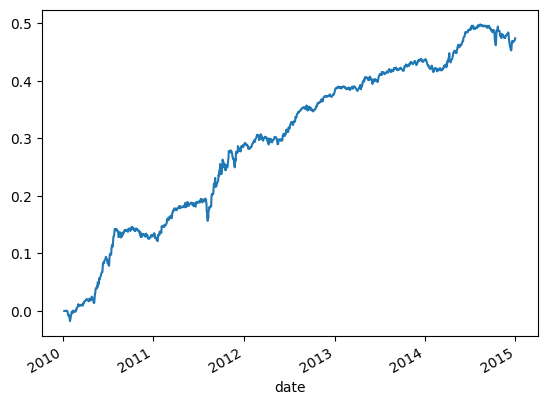

In [102]:
alpha_stats(data_returns, algh_alpha_reversion(n=5, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=True, decaying=False))

#### Task 2
$$ kernel (d) = {high(d) - low(d)} $$
$$ \alpha (d) = {high(d) - low(d) \over open(d)} $$


In [72]:
def algh_alpha_high_minus_low(n=0, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_high - data_low) 
    alpha = kernel / data_open.shift(n)
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [73]:
generate_alphas(data_returns, algh_alpha_high_minus_low, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, filename='stats_alpha_high_minus_low.txt')

0.04551137257931056
0.03598262649203005
0.009123976718465338
-0.009360953380178212
-0.016745522831136096
-0.025771271917190523
-0.028236827199748585
-0.01594830778038718
-0.011740651529059974
-0.01085483176682303


best alpha

In [26]:
alpha_stats(data_returns, algh_alpha_high_minus_low(data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=True, decaying=True, decay_d=10, decay_k=9))

nan


####
$$ kernel (d) = {high(d) \over low(d)} $$
$$ \alpha (d) = kernel - 1 $$


In [105]:
def algh_alpha_high_over_low(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = data_high / data_low.shift(n)
    alpha = kernel - 1
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return -alpha

In [75]:
generate_alphas(data_returns, algh_alpha_high_over_low, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, filename='stats_alpha_high_over_low.txt')

-0.12153904402408129
-0.23814962570669782
-0.34613257744962744
-0.3842299668071632
-0.39799832225972054
-0.3945301664010565
-0.356567382094156
-0.3326781536960114
-0.26686161940072284
-0.20663674866054474


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.070528,0.506772,1.575180,3.555677,05.02.2010,08.02.2010
2011,0.115706,0.530017,1.755972,0.187977,03.01.2011,10.01.2011
2012,0.070976,0.523489,2.140906,0.081864,03.01.2012,19.01.2012
2013,0.013642,0.512197,0.486501,0.030323,03.01.2013,15.03.2013
2014,0.050570,0.514990,1.259255,0.026270,02.01.2014,10.01.2014


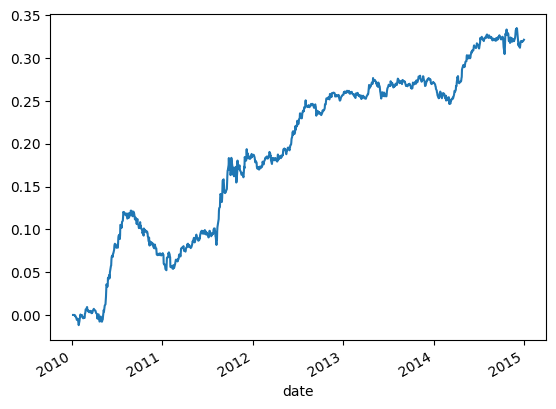

In [107]:
alpha_stats(data_returns, algh_alpha_high_over_low(n=5, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=True, decaying=False))

#### Task 3

$$ kernel(d) = high(d) + low(d) - 2*close(d)$$ 
$$ alpha(d) = kernel(d) $$ 

In [76]:
def algh_alpha_high_plus_low_minus_two_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = data_high + data_low - 2 * data_close
    alpha = kernel / data_open.shift(n)
    if decaying==True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [77]:
generate_alphas(data_returns, algh_alpha_high_plus_low_minus_two_close, max_n=10, data_close=data_close, data_open = data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_high_plus_low_minus_two_close.txt')

0.5529985558264219
0.5530856579093323
0.5561659676376336
0.5634293086155883
0.5618771313813121
0.5644384484065619
0.561656265684817
0.5539407608036185
0.5575733071111536
0.5572693581670429


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.145720,1.334321,2.719832,0.568818,21.01.2010,26.01.2010
2011,0.135544,1.393849,1.804475,0.257732,08.04.2011,19.08.2011
2012,0.116367,1.382289,2.804333,0.050840,23.02.2012,02.03.2012
2013,0.101440,1.388636,2.513952,0.031558,17.01.2013,17.04.2013
2014,0.058198,1.396774,1.282599,0.043238,12.08.2014,15.12.2014


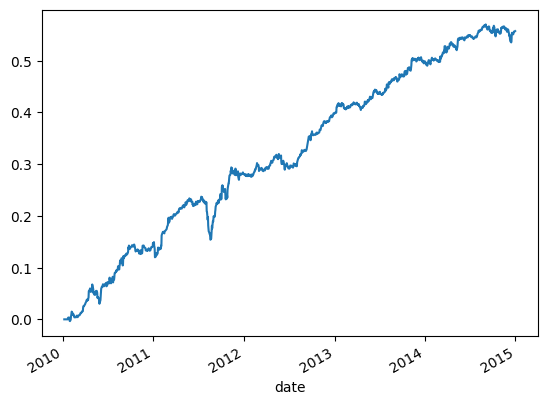

In [112]:
alpha_stats(data_returns, 
            (n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.163848,0.897971,3.429022,0.637368,07.01.2010,28.01.2010
2011,0.198161,0.901908,2.617816,0.159150,11.07.2011,19.08.2011
2012,0.147639,0.885029,3.671035,0.020263,21.02.2012,02.03.2012
2013,0.099851,0.889676,2.641922,0.018078,09.01.2013,26.02.2013
2014,0.085242,0.904860,1.772636,0.061528,05.08.2014,15.12.2014


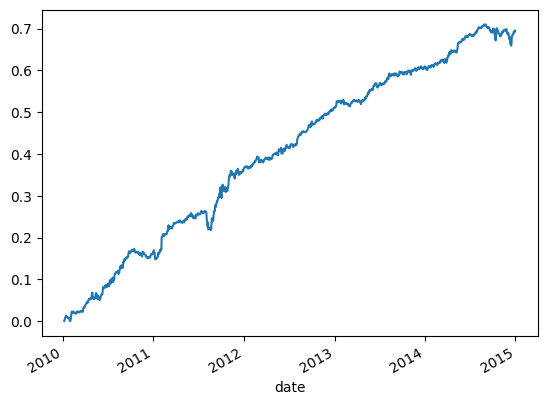

In [111]:
alpha_stats(data_returns, algh_alpha_high_plus_low_minus_two_close(n=1, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=4, decay_k=3))

$$ kernel(d) = {high(d) * low(d) \over close^2(d)} $$
$$ \alpha(d) = kernel $$

In [114]:
def algh_alpha_high_mul_low_over_close2(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_high * data_low) / data_close.shift(n) ** 2
    alpha = kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return -alpha

In [79]:
generate_alphas(data_returns, algh_alpha_high_mul_low_over_close2, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_alpha_high_mul_low_over_close2.txt')

-0.15379794049191267
-0.28546323578697774
-0.3027355392719586
-0.272716708875159
-0.3660491058580775
-0.374279683432978
-0.34429441136542627
-0.31374312811418564
-0.2680230659399206
-0.16924203028100832


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.087858,0.558983,1.418029,2.276865,14.01.2010,28.01.2010
2011,0.049638,0.574715,0.358705,0.621574,03.01.2011,11.01.2011
2012,0.121308,0.569722,2.795285,0.085352,29.06.2012,24.09.2012
2013,0.066678,0.565850,1.051016,0.039422,15.04.2013,24.06.2013
2014,0.048798,0.561189,0.711934,0.113845,09.06.2014,13.10.2014


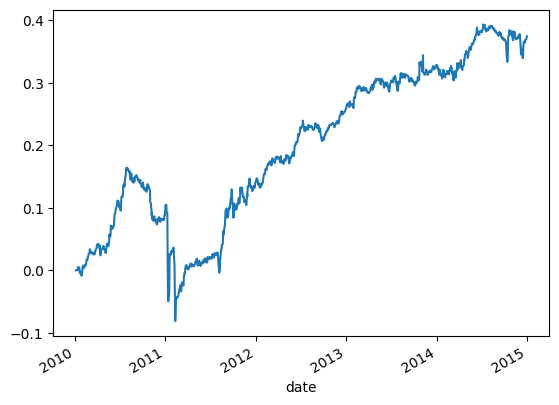

In [115]:
alpha_stats(data_returns, algh_alpha_high_mul_low_over_close2(n=6, data_close=data_close, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

$$ kernel(d) = {high(d) + low(d) \over 2} < close(d)?    1:-1 $$
$$ \alpha(d) = kernel(d) * \left({close(d) \over close(d - n)}\right) $$

In [118]:
def algh_high_plus_low_less_two_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_high + data_low < 2 * data_close.shift(n)).replace({True: 1, False: -1})
    alpha = kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    alpha = kernel * data_close / data_close.shift(n)
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [81]:
generate_alphas(data_returns, algh_high_plus_low_less_two_close, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_high_plus_low_less_two_close.txt')

-0.012150018231444605
-0.20624984367382548
-0.2352708142691324
-0.2664380000647136
-0.2911806441484753
-0.2637709502901725
-0.2379698761958987
-0.23295780140949374
-0.1704252408205832
-0.15272632064863031


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.082197,0.634852,2.682273,0.303423,13.01.2010,15.01.2010
2011,0.104183,0.718403,2.320641,0.089792,03.01.2011,12.01.2011
2012,0.055502,0.641129,2.450454,0.084363,22.02.2012,16.05.2012
2013,0.030921,0.614423,1.572402,0.034321,23.05.2013,03.06.2013
2014,0.018377,0.604843,0.691447,0.034806,02.01.2014,21.01.2014


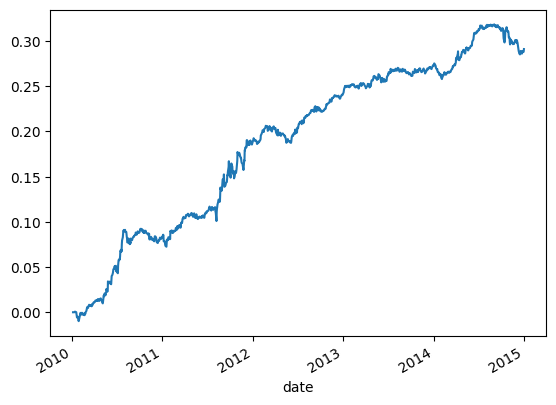

In [119]:
alpha_stats(data_returns, algh_high_plus_low_less_two_close(n=5, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=5))

#### Task 4
$$ kernel(d) = {open(d) \over close(d)} $$
$$ \alpha(d) = kernel(d) - 1 $$

In [129]:
def algh_open_over_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = data_open / data_close.shift(n)
    alpha = kernel - 1
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return -alpha

KeyboardInterrupt: 

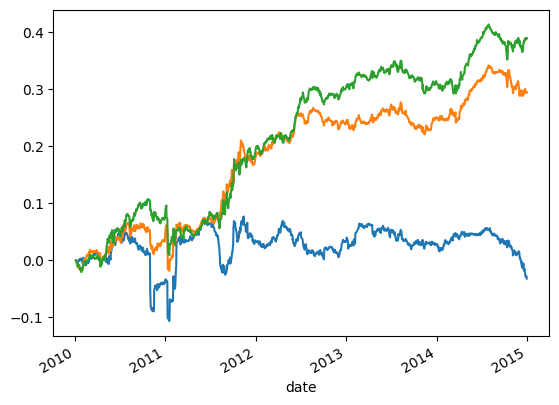

In [125]:
generate_alphas(data_returns, algh_open_over_close, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_open_over_close.txt')

best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,-0.001962,0.678005,-0.029891,1.656694,19.01.2010,20.01.2010
2011,-0.080442,0.659850,-0.799621,2.792693,03.01.2011,11.01.2011
2012,0.005027,0.659354,0.125330,-0.005326,26.12.2012,28.12.2012
2013,-0.035553,0.646800,-0.805388,-0.012815,30.12.2013,31.12.2013
2014,-0.034088,0.665644,-0.706246,-0.001553,30.12.2014,31.12.2014


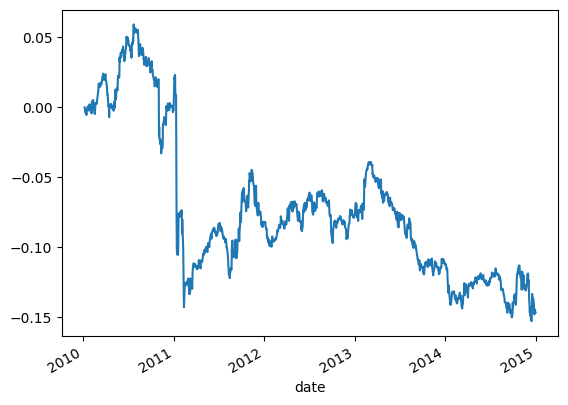

In [131]:
alpha_stats(data_returns, algh_open_over_close(n=1, data_close=data_close, data_open=data_open, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=5))

$$ kernel(d) = {high(d) - low(d) \over close(d)} $$
$$ \alpha(d) = {close(d) - open(d) \over kernel(d) * close(d)} + 0.001$$

In [134]:
def algh_high_minus_law_over_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_low - data_high)
    alpha = (data_close.shift(n) - data_open) / (kernel + 0.001)
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return -alpha

In [85]:
generate_alphas(data_returns, algh_high_minus_law_over_close, max_n=10,  data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_high_minus_law_over_close.txt')

-0.00424018243968774
-0.5331884196097323
-0.5696089609672392
-0.40958381902929347
-0.8148588055204896
-0.6295618403902669
-0.6914061521747394
-0.5123299185464505
-0.5730947839134372
-0.5054675679462145


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.238068,0.900434,3.230755,0.420103,13.01.2010,15.01.2010
2011,0.265786,0.939669,2.987635,0.041079,05.01.2011,14.01.2011
2012,0.238977,0.912963,1.452396,0.071587,22.02.2012,10.04.2012
2013,0.043467,0.921013,0.444243,0.070457,10.05.2013,16.05.2013
2014,0.028561,0.847603,0.744624,0.047126,08.07.2014,15.12.2014


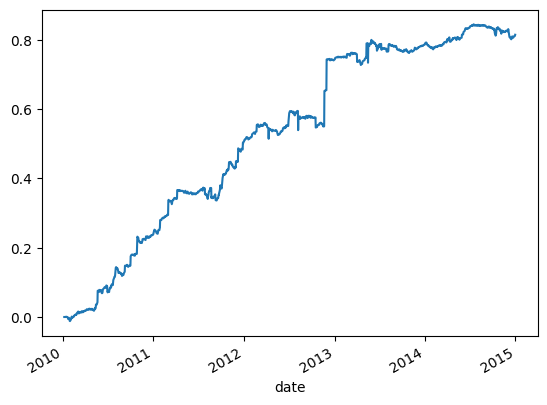

In [135]:
alpha_stats(data_returns, algh_high_minus_law_over_close(n=5, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.174396,0.816544,2.128126,0.541846,18.02.2010,22.02.2010
2011,0.322932,0.862597,3.258367,0.138657,19.07.2011,08.08.2011
2012,0.065864,0.815479,0.424463,0.150586,03.07.2012,07.08.2012
2013,0.119510,0.825007,1.457442,0.049781,04.03.2013,15.04.2013
2014,0.008704,0.745996,0.209759,0.054405,03.07.2014,15.12.2014


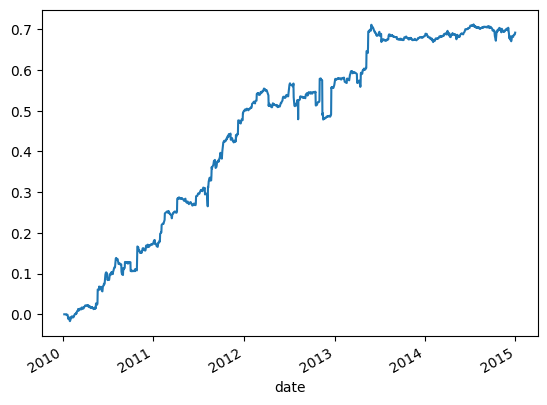

In [136]:
alpha_stats(data_returns, algh_high_minus_law_over_close(n=7, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.062133,1.349871,1.896509,0.207313,07.01.2010,08.01.2010
2011,0.030687,1.356674,0.661084,0.070412,03.01.2011,04.01.2011
2012,0.044265,1.343289,1.720760,0.035909,03.01.2012,17.01.2012
2013,0.021900,1.340931,1.001207,0.084486,16.01.2013,03.06.2013
2014,-0.017706,1.349168,-0.661698,0.098028,02.01.2014,28.03.2014


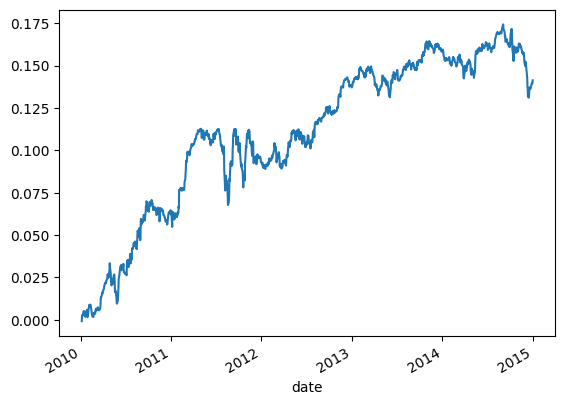

In [ ]:
alpha_stats(data_returns, algh_high_minus_law_over_close(data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.107383,0.751214,3.256950,0.207313,07.01.2010,08.01.2010
2011,0.109743,0.726104,2.353840,0.036012,03.01.2011,04.01.2011
2012,0.094067,0.726614,3.508525,0.050218,23.02.2012,02.03.2012
2013,0.067839,0.718927,2.678392,0.029711,05.02.2013,17.04.2013
2014,0.022568,0.732431,0.686232,0.091944,08.07.2014,15.12.2014


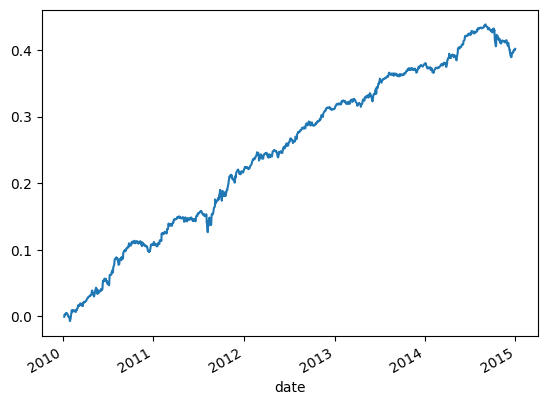

In [ ]:
alpha_stats(data_returns, algh_high_minus_law_over_close(data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=5))

#### Task 5

$$ kernel(d) = {close(d) - low(d) \over high(d) - low(d)} $$

In [138]:
def algh_close_minus_low_over_high_minus_low(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_close.shift(n) - data_low) / (data_high - data_low)
    alpha = kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [87]:
generate_alphas(data_returns, algh_close_minus_low_over_high_minus_low, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_close_minus_low_over_high_minus_low.txt')

-0.07578197864418885
-0.2106055239221071
-0.2557814973562868
-0.1785037049171358
-0.2572244102732175
-0.27997828646836975
-0.31449417519112066
-0.29989188680966455
-0.2418593143712549
-0.1929886837451506


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.080246,0.697824,2.277224,0.335135,09.03.2010,22.03.2010
2011,0.128212,0.700890,2.536358,0.127022,15.09.2011,04.10.2011
2012,0.049147,0.727287,1.372576,0.086725,20.03.2012,18.05.2012
2013,0.002899,0.643328,0.120069,0.033974,04.01.2013,24.06.2013
2014,0.009728,0.738479,0.248486,0.092341,02.06.2014,15.12.2014


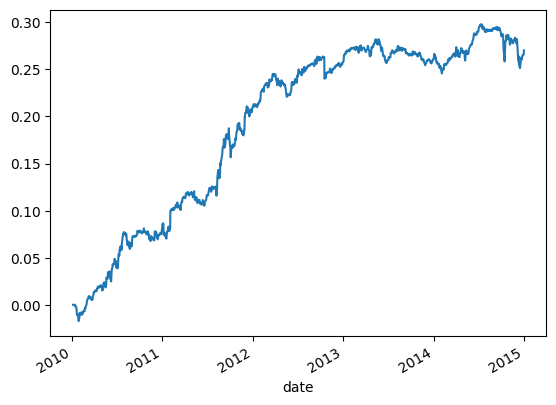

In [139]:
alpha_stats(data_returns, algh_close_minus_low_over_high_minus_low(n=7, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.099831,0.740611,3.195822,5.950220,06.01.2010,28.01.2010
2011,0.122343,0.719733,2.546407,0.049310,03.01.2011,04.01.2011
2012,0.098042,0.708418,3.989641,0.017176,08.02.2012,02.03.2012
2013,0.074981,0.712466,3.731175,0.026253,11.03.2013,17.04.2013
2014,0.042794,0.780602,1.626374,0.046866,13.08.2014,15.12.2014


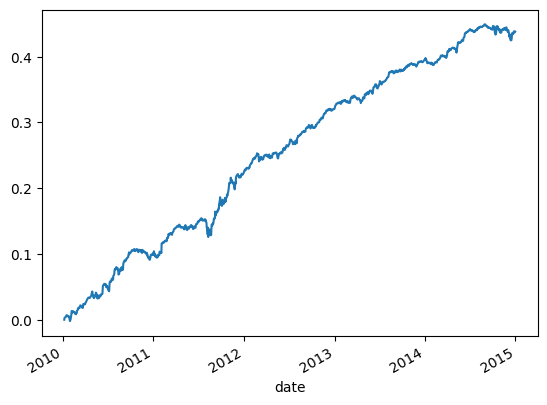

In [ ]:
alpha_stats(data_returns, algh_close_minus_low_over_high_minus_low(data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, ranking=False, decaying=True, decay_d=10, decay_k=5))

$$ kernel(d) = {close(d) - low(d) \over high(d) - low(d)} < 0.5 ? 1 :-1$$

In [88]:
def algh_close_minus_low_over_high_minus_low_less_half(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = ((data_close - data_low) / (data_high - data_low) < 0.5).replace({True: 1, False: -1})
    alpha = kernel * (data_close / data_close.shift(n) - 1)
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking ==True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [89]:
generate_alphas(data_returns, algh_close_minus_low_over_high_minus_low_less_half, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0.01, cut_outliers_coef=0.01, filename='stats_close_minus_low_over_high_minus_low_less_half.txt')

0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505
0.18714071598457505


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.051641,1.225695,1.700334,20.665613,06.01.2010,28.05.2010
2011,0.060008,1.230227,1.320624,0.073454,03.01.2011,04.01.2011
2012,0.042648,1.169578,2.078221,0.036601,21.02.2012,02.03.2012
2013,0.027260,1.151798,1.608834,0.069565,18.03.2013,17.04.2013
2014,0.005584,1.170515,0.286621,0.056509,02.01.2014,26.03.2014


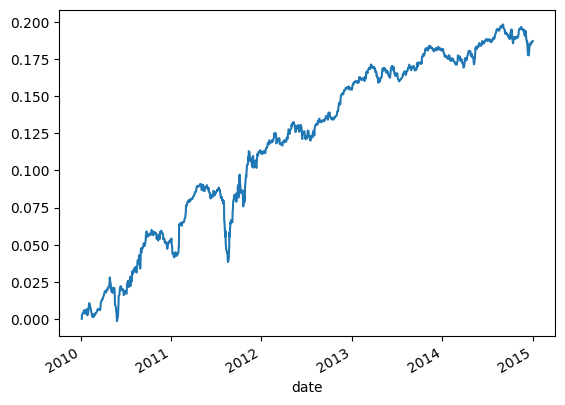

In [ ]:
alpha_stats(data_returns, algh_close_minus_low_over_high_minus_low_less_half(data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False))

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,-0.040429,0.763306,-0.609732,9.752665,11.01.2010,12.04.2010
2011,0.104536,0.762460,1.044357,0.213421,19.01.2011,03.02.2011
2012,0.026288,0.764389,0.548417,0.435208,05.01.2012,13.02.2012
2013,-0.016186,0.771861,-0.358297,0.121704,02.01.2013,26.12.2013
2014,0.070805,0.740794,1.162869,0.367920,02.01.2014,04.03.2014


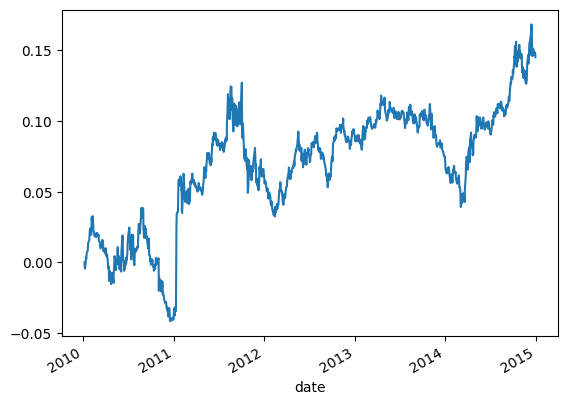

In [ ]:
alpha_stats(data_returns, algh_close_minus_low_over_high_minus_low_less_half(data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=5, decay_k=3))

#### Task 6

$$ kernel(d) = correlation((volume(d), close(d), 20) $$
$$ \alpha(d) = kernel(d) $$

In [ ]:
'''corr_matrix = pd.DataFrame()
for j in tqdm(range(data_close.shape[1])):
    temp = []
    for i in range(data_close.shape[0] - 20):
        temp.append(scipy.stats.pearsonr(data_close[j].iloc[i : i + 20], data_volume[j].iloc[i : i + 20])[0])
    corr_matrix[j] = np.array(temp)

corr_volume_close = pd.concat([pd.DataFrame(np.zeros((20, data_close.shape[1]))), corr_matrix])
corr_volume_close.index = data_close.index
corr_volume_close.to_csv('corr_volume_close')
'''

"corr_matrix = pd.DataFrame()\nfor j in tqdm(range(data_close.shape[1])):\n    temp = []\n    for i in range(data_close.shape[0] - 20):\n        temp.append(scipy.stats.pearsonr(data_close[j].iloc[i : i + 20], data_volume[j].iloc[i : i + 20])[0])\n    corr_matrix[j] = np.array(temp)\n\ncorr_volume_close = pd.concat([pd.DataFrame(np.zeros((20, data_close.shape[1]))), corr_matrix])\ncorr_volume_close.index = data_close.index\ncorr_volume_close.to_csv('corr_volume_close')\n"

In [90]:
crr_vol_cls = pd.read_csv('corr_volume_close.csv', index_col='date')
crr_vol_cls.index = crr_vol_cls.index.astype('datetime64').rename('date')

In [91]:
def algh_corr_volume_close(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = crr_vol_cls * data_close / data_close.shift(n)
    alpha = kernel
    if decaying == True:
        alpha = get_decay_alpha(alpha, decay_d, decay_k)
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [92]:
generate_alphas(data_returns, algh_corr_volume_close, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, filename='stats_corr_volume_close.txt')

-0.016989101801737853
-0.013997810552168706
-0.012385518494503395
-0.0075013672607913105
-0.010886578659805702
-0.006311827115547669
-0.004658188924529724
-0.003008205028705538
-0.001434594823645817
-0.0013600637404525622


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.019606,0.197564,0.823875,0.045101,04.02.2010,05.02.2010
2011,-0.024184,0.223259,-0.741867,0.086091,03.01.2011,02.09.2011
2012,-0.021379,0.221721,-1.242877,-0.014934,27.12.2012,31.12.2012
2013,0.045989,0.218991,2.280116,0.882848,08.07.2013,11.07.2013
2014,-0.018178,0.218277,-0.793475,0.370249,02.01.2014,09.05.2014


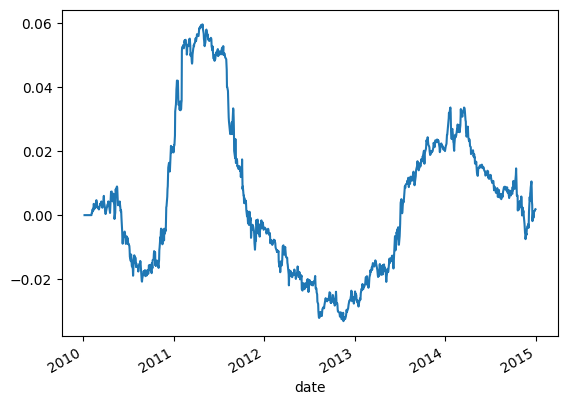

In [ ]:
alpha_stats(data_returns, algh_corr_volume_close(cut_middle_coef=0.01, cut_outliers_coef=0.01, ranking=False, decaying=True, decay_d=5, decay_k=4))

$$ kernel(d) = correlation((high(d) - low(d), return), 20) $$
$$ \alpha(d) = kernel(d) $$

In [ ]:
'''
corr_matrix = pd.DataFrame()
a = data_high - data_low
for j in tqdm(range(data_returns.shape[1])):
    temp = []
    for i in range(data_returns.shape[0] - 20):
        temp.append(scipy.stats.pearsonr(a[str(j)].iloc[i : i + 20], data_returns[str(j)].iloc[i : i + 20])[0])
    corr_matrix[j] = np.array(temp)

corr_high_minus_low_and_return = pd.concat([pd.DataFrame(np.zeros((20, data_returns.shape[1]))), corr_matrix])
corr_high_minus_low_and_return.index = data_returns.index
corr_high_minus_low_and_return.to_csv('corr_high_minus_low_and_return.csv')
'''

"\ncorr_matrix = pd.DataFrame()\na = data_high - data_low\nfor j in tqdm(range(data_returns.shape[1])):\n    temp = []\n    for i in range(data_returns.shape[0] - 20):\n        temp.append(scipy.stats.pearsonr(a[str(j)].iloc[i : i + 20], data_returns[str(j)].iloc[i : i + 20])[0])\n    corr_matrix[j] = np.array(temp)\n\ncorr_high_minus_low_and_return = pd.concat([pd.DataFrame(np.zeros((20, data_returns.shape[1]))), corr_matrix])\ncorr_high_minus_low_and_return.index = data_returns.index\ncorr_high_minus_low_and_return.to_csv('corr_high_minus_low_and_return.csv')\n"

In [93]:
crr_hgh_mns = pd.read_csv('corr_high_minus_low_and_return.csv', index_col='date')
crr_hgh_mns.index = crr_hgh_mns.index.astype('datetime64').rename('date')

In [94]:
def algh_corr_high_minus_low_and_return(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = crr_hgh_mns * data_close / data_close.shift(n)
    alpha = kernel
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [95]:
generate_alphas(data_returns, algh_corr_high_minus_low_and_return, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, filename='stats_corr_high_minus_low_and_return.txt')

-0.01125933691297597
-0.005553519042302121
-0.00037551826395328916
0.004735236977618672
0.004938848121436191
0.002015028672470808
0.0036806609539267775
0.0065484529326256345
0.004830987733378033
0.006104819504512607


best alpha

,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.041764,0.221753,1.713497,0.343489,04.02.2010,11.02.2010
2011,-0.031545,0.251380,-0.898458,0.927467,03.01.2011,07.10.2011
2012,-0.031965,0.239369,-1.646206,0.440253,03.01.2012,26.01.2012
2013,0.022433,0.232800,1.131865,4.227061,18.04.2013,19.04.2013
2014,-0.005254,0.238617,-0.204103,0.764096,02.01.2014,03.01.2014


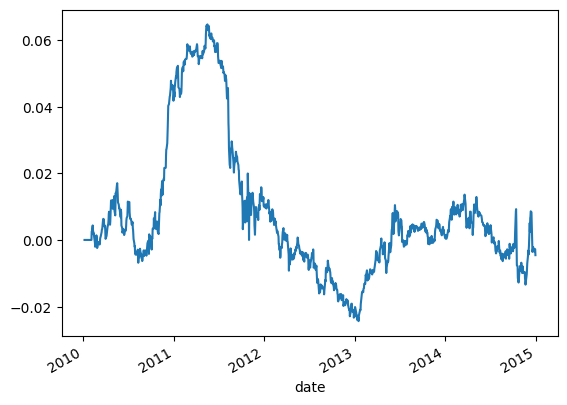

In [ ]:
alpha_stats(data_returns, algh_corr_high_minus_low_and_return(cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=5))

Add alpha

In [141]:
def algh_close_minus_close_over_high_minus_low(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = (data_close - data_close.shift(n)) / (data_high - data_low)
    alpha = -kernel
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [97]:
generate_alphas(data_returns, algh_close_minus_close_over_high_minus_low, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, filename='stats_close_minus_close_over_high_minus_low.txt')

-0.14762040896760012
-0.24998846687828347
-0.284234664106835
-0.20551028813368785
-0.27783413023634923
-0.29477880566155495
-0.32981490953341885
-0.3155676370519753
-0.25475948975267104
-0.2062582508414637


,years_pnl_cum,turnover,sharpe_coef,drawdown,drawdown_day_start,drawdown_day_end
date,,,,,,
2010,0.075581,0.334001,2.202660,0.170539,06.04.2010,12.04.2010
2011,0.169902,0.312236,3.737232,0.024526,03.01.2011,04.01.2011
2012,0.054957,0.386543,1.627829,0.065585,18.09.2012,17.10.2012
2013,0.017328,0.403285,0.812619,0.029112,07.03.2013,03.04.2013
2014,0.012047,0.564084,0.311111,0.063031,18.03.2014,15.12.2014


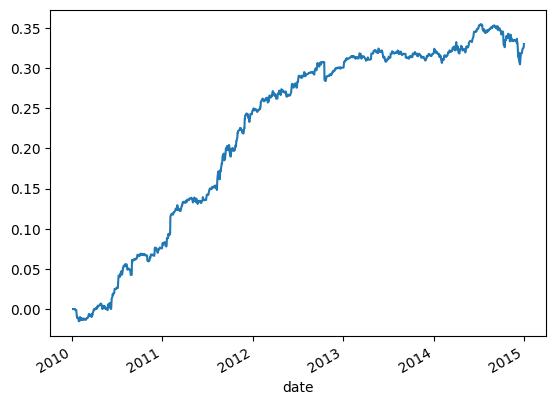

In [142]:
alpha_stats(data_returns, algh_close_minus_close_over_high_minus_low(n=7, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=True, decay_d=10, decay_k=5))

add alpha

In [98]:
def algh_crr_close_minus_close_over_high_minus_low(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = crr_hgh_mns * (data_close - data_close.shift(n)) / (data_high - data_low)
    alpha = kernel
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha

In [99]:
generate_alphas(data_returns, algh_crr_close_minus_close_over_high_minus_low, max_n=10, data_close=data_close, data_open=data_open, data_high=data_high, data_low=data_low, cut_middle_coef=0, cut_outliers_coef=0, filename='stats_crr_close_minus_close_over_high_minus_low.txt')

-0.13989153003206287
-0.031208064477510393
0.03260940226160304
0.1219769713915677
0.1330997595462871
0.08799548252215426
0.10666810938870112
0.10427989998986271
0.13029509810693063
0.1024925509880602


add alpha

In [ ]:
def algh_crr_close_minus_close_over_high_minus_low(n=1, data_close=0, data_open=0, data_high=0, data_low=0, volume=0,cut_middle_coef=0, cut_outliers_coef=0, ranking=False, decaying=False, decay_d=0, decay_k=0):
    kernel = crr_vol_cls * (data_close - data_close.shift(n)) / (data_high - data_low)
    alpha = kernel
    if ranking == True:
        alpha = alpha.T.apply(lambda x: get_rank(x)).T
    alpha = alpha.T.apply(lambda x: cut_outliers(x, cut_outliers_coef)).apply(lambda x: cut_middle(x, cut_middle_coef)).apply(neutralize).apply(normalize).T
    return alpha